In [168]:
import sys
import cv2
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import exposure

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.model_selection import train_test_split

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(4);

Using TensorFlow backend.


In [158]:
def remove_background_noise(im):
    #stretch contrast to have only binary valued pixels
    processed = exposure.rescale_intensity(processed, in_range=(1, 0))
    processed = cv2.cvtColor(processed,cv2.COLOR_GRAY2RGB)
    
    return processed

In [117]:
def get_bound_regions(im, method = 'f'):
    #see https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/

    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(im)

    # Switch to fast but low recall Selective Search method
    if (method == 'f'):
        ss.switchToSelectiveSearchFast()

    # Switch to high recall but slow Selective Search method
    else:
        ss.switchToSelectiveSearchQuality()


    # run selective search segmentation on input image
    rects = ss.process()
    
    return rects

In [ ]:
def get_best_regions(rects, h, w):
    #To improve
    best_rect = None
    max_bound_area = 0   
    limit = h*w
    
    for rect in rects:
        bound_area = rect[2]*rect[3]
        if bound_area > max_bound_area and bound_area < limit:
            max_bound_area = rect[2]*rect[3]
            best_rect = rect
        
    return [best_rect] 

def get_best_regions2(rects, h, w):
    length = len(rects)
    return rects[0:min(length, 3)]

In [36]:
def display_image_with_bound(im, procesed, bound_regions, cropped):
    # create a copy of original image
    imOut = im.copy()

    for i, bound_region in enumerate(bound_regions):
        x, y, w, h = bound_region
        cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

    # show output
    plt.subplot(141),plt.imshow(im), plt.title('input')
    plt.subplot(142),plt.imshow(procesed), plt.title('processed')
    plt.subplot(143),plt.imshow(imOut), plt.title('result')
    plt.subplot(144),plt.imshow(cropped), plt.title('cropped/resized')
    plt.show()

In [210]:
#This method calls the above three and returns a (resized) cropped image
def find_best_bound_region(im_orig, display=False):
    
    im_processed = remove_background_noise(im_orig/255.0)
    bound_regions = get_bound_regions(im_processed)
    best_regions = get_best_regions(bound_regions, im_processed.shape[0], im_processed.shape[1])
    x,y,w,h = best_regions[0][0], best_regions[0][1], best_regions[0][2], best_regions[0][3]
    im_cropped = im_processed[y:y+h, x:x+w]
    image_resized = resize(im_cropped, (im_orig.shape[0], im_orig.shape[1]))
    if display:
        display_image_with_bound(im_orig, im_processed, best_regions, image_resized)
    return image_resized


In [7]:
X_data = pd.read_pickle('data/train_images.pkl')
y_data = pd.read_csv('data/train_labels.csv')
X_test = pd.read_pickle('data/test_images.pkl')

0 5


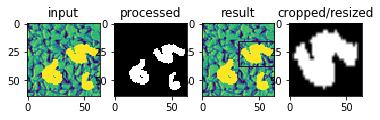

1 2


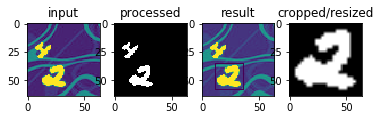

2 6


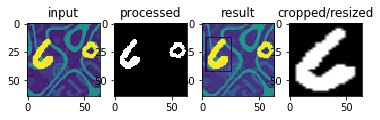

3 9


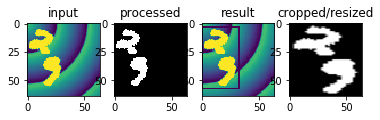

4 9


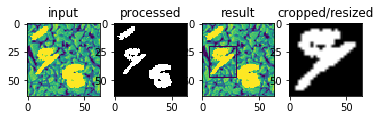

5 3


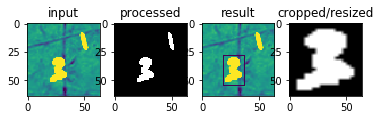

6 3


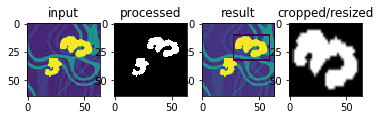

7 4


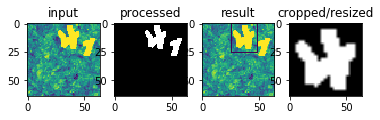

8 3


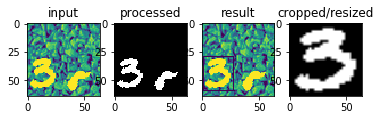

9 0


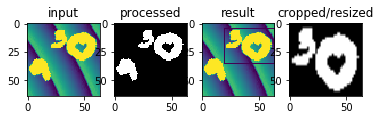

10 5


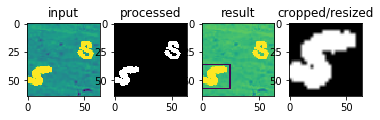

11 2


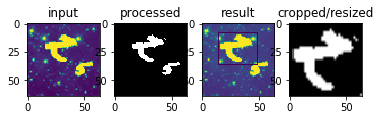

12 5


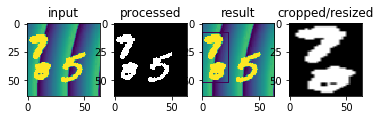

13 6


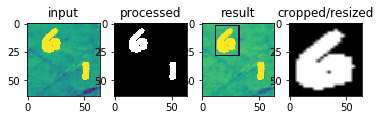

14 1


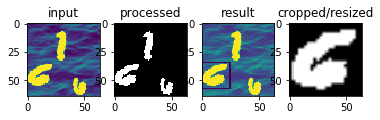

15 9


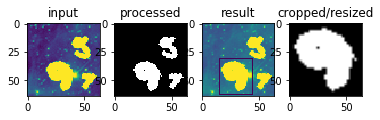

16 6


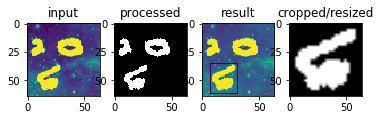

17 1


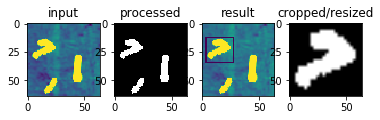

18 9


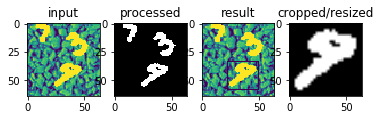

19 2


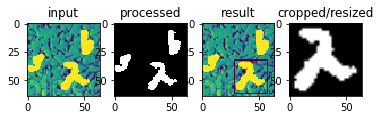

In [159]:
#visualize results
j=0
for i in np.random.randint(0, len(X_data), size=(20,)):
    print(j, y_data['Category'].iloc[i])
    find_best_bound_region(X_data[i], display=True)
    j+=1

In [ ]:
def pre_process_images(X_data):
    X_data_processed = []
    
    for i in range(len(X_data)):
        X_data_processed.append(find_best_bound_region(X_data[i]))
        if i%5000==0:
            print(i) 
    
    return np.array(X_data_processed)
    

In [ ]:
X_data_processed = pre_process_images(X_data)

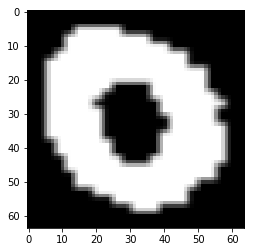

In [135]:
plt.imshow(X_data_processed[2])

In [186]:
X_data_processed2 = X_data_processed[:, :, :, 0].reshape(X_data_processed.shape[0], 64, 64, 1)
y_data = keras.utils.to_categorical(y_data['Category'])

X_data_processed2.shape

(40000, 64, 64, 1)

In [187]:
X_train, X_val, y_train, y_val = train_test_split(X_data_processed2, y_data, test_size=0.2, random_state=39)

In [172]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,1)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val))

Train on 128000 samples, validate on 32000 samples
Epoch 1/1
120192/128000 [===========================>..] - ETA: 14:02 - loss: 1.0213 - acc: 0.6846

In [215]:
model.save('model.h5')

In [216]:
X_data_processed = pre_process_images(X_test)
X_test_processed2 = X_test_processed[:,:,:,0].reshape(X_test_processed.shape[0], 64, 64, 1)
print(X_test_processed2.shape)

(10000, 64, 64, 1)

In [ ]:
predictions = model.predict_classes(X_test_processed_f, verbose=2)
pd.DataFrame(predictions).to_csv("mnist_prediction.csv")

In [221]:
#see prediction distribution
y = np.bincount(predictions)
ii = np.nonzero(y)[0]
print(ii)
print(y[ii])

[0 1 2 3 4 5 6 7 8 9]
[1335  856 1090  962  915  871  980 1137  927  927]
